In [1]:
## anaconda3 (Python 3.12.0) Kernel

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [2]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_3474/3199335484.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [ ]:
working_pairs = [('5401 JP Equity', '8604 JP Equity'), ('6273 JP Equity', '9984 JP Equity'), ('8053 JP Equity', '8058 JP Equity'), ('7733 JP Equity', '9613 JP Equity'), ('4684 JP Equity', '7832 JP Equity'), ('6762 JP Equity', '6857 JP Equity'), ('9020 JP Equity', '9022 JP Equity'), ('7267 JP Equity', '8306 JP Equity'), ('8308 JP Equity', '8802 JP Equity'), ('4901 JP Equity', '6702 JP Equity'), ('6503 JP Equity', '7269 JP Equity'), ('7267 JP Equity', '8801 JP Equity'), ('4519 JP Equity', '7532 JP Equity'), ('6988 JP Equity', '7267 JP Equity'), ('6326 JP Equity', '6954 JP Equity'), ('6752 JP Equity', '8604 JP Equity'), ('4901 JP Equity', '9613 JP Equity')]
# TODO update working pairs with new 10
top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]

In [4]:
top_keys

['5401 JP Equity 8604 JP Equity',
 '6273 JP Equity 9984 JP Equity',
 '8053 JP Equity 8058 JP Equity',
 '7733 JP Equity 9613 JP Equity',
 '4684 JP Equity 7832 JP Equity',
 '6762 JP Equity 6857 JP Equity',
 '9020 JP Equity 9022 JP Equity',
 '7267 JP Equity 8306 JP Equity',
 '8308 JP Equity 8802 JP Equity',
 '4901 JP Equity 6702 JP Equity',
 '6503 JP Equity 7269 JP Equity',
 '7267 JP Equity 8801 JP Equity',
 '4519 JP Equity 7532 JP Equity',
 '6988 JP Equity 7267 JP Equity',
 '6326 JP Equity 6954 JP Equity',
 '6752 JP Equity 8604 JP Equity',
 '4901 JP Equity 9613 JP Equity']

In [5]:
# # Sort the keys by their cumpnl[-2] values in descending order
# top_keys = sorted(
#     pairsOutcome,
#     key=lambda k: pairsOutcome[k].cumpnl.iloc[-2],  # Access cumpnl[-2] safely
#     reverse=True
# )[:10]  # Get the top 10 keys

# Print the top 10 performing trades
print("Top 10 performing trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Return: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

Top 10 performing trades:
1. Key: 5401 JP Equity 8604 JP Equity, Return: 0.01
2. Key: 6273 JP Equity 9984 JP Equity, Return: 0.99
3. Key: 8053 JP Equity 8058 JP Equity, Return: 0.52
4. Key: 7733 JP Equity 9613 JP Equity, Return: 0.34
5. Key: 4684 JP Equity 7832 JP Equity, Return: 0.89
6. Key: 6762 JP Equity 6857 JP Equity, Return: -0.67
7. Key: 9020 JP Equity 9022 JP Equity, Return: 0.31
8. Key: 7267 JP Equity 8306 JP Equity, Return: 1.16
9. Key: 8308 JP Equity 8802 JP Equity, Return: 0.43
10. Key: 4901 JP Equity 6702 JP Equity, Return: -0.34
11. Key: 6503 JP Equity 7269 JP Equity, Return: 1.33
12. Key: 7267 JP Equity 8801 JP Equity, Return: 0.64
13. Key: 4519 JP Equity 7532 JP Equity, Return: 1.14
14. Key: 6988 JP Equity 7267 JP Equity, Return: 0.65
15. Key: 6326 JP Equity 6954 JP Equity, Return: 1.19
16. Key: 6752 JP Equity 8604 JP Equity, Return: -0.48
17. Key: 4901 JP Equity 9613 JP Equity, Return: 1.10


# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Steps
#### Environment:
- State Space: A set of all possible states the agent can be in.  
  - [spread, mid, 2 sd low, 1 sd low, 1 sd high, 2 sd high]
- Action Space: A set of all possible actions the agent can take in each state.   
  - [-1, # short\
      0, # uninvested\
      1  # long]   
- Reward Function: A function that assigns a numerical reward to each state-action pair, indicating the immediate consequence of taking a particular action in a specific state.
  - dailypnl
- Transition Function: A function that determines the probability of transitioning from one state to another when a particular action is taken.
  - deterministic based on historical performance
#### Agent:

- Q-Table: A matrix that stores the estimated Q-values for each state-action pair. Q-values represent the expected future reward for taking a specific action in a given state.   
  - continuous Q table?
- Learning Rate (α): A parameter that controls how much the Q-values are updated with each new experience.   
- Discount Factor (γ): A parameter that determines the importance of future rewards. A higher discount factor gives more weight to future rewards.   
- Exploration Rate (ε): A parameter that controls the balance between exploration (trying new actions) and exploitation (choosing the action with the highest Q-value).   
- Q-Learning Algorithm:

  - Initialization: Initialize the Q-table with random values or zeros.   
  - Exploration and Exploitation: Use an exploration strategy (e.g., ε-greedy) to choose an action:
    - With probability ε, choose a random action.   
    - With probability 1-ε, choose the action with the highest Q-value for the current state.   
  
  - Take Action: Execute the chosen action in the environment.   
  - Observe Reward and Next State: Observe the immediate reward and the next state resulting from the action.
- Update Q-Value: Update the Q-value of the current state-action pair using the following formula:

#### Training and Test set

2013 is used for warm start\
2014 - 2023 train data since NN need a lot of training data {end 2023 idx == 2868}\
2024 onwards (5 months) test data


In [6]:
## Get pair stock data
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_3474/2263820838.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


In [7]:
rollingWindow = 262
cutLossSd = 2

In [8]:
for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

## Make indicators and spread stationary around 0
Deduct the mean from all values to translate to 0 axis

In [9]:
workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[top_keys[0]].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['spread','1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

In [10]:
workingPairOutcome[top_keys[5]][-5:]  

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0]])

In [11]:
# workingPairOutcome = {top_keys[0]:workingPairOutcome[top_keys[0]]}

- Test one timestep at a time (even though we can test all at the same time)
- give state
- Trading should be path dependent due to stop loss. in this case I can only give last position as one of the parameters

In [12]:
import gym
import random

class PairTradeEnv(gym.Env):
    # ... (define your environment's state space, action space, etc.)
    def __init__(self, workingPairOutcome, top_keys, validPairsList, return_df):
        # ... (initialize other parameters)
        self.earliest_step = 261  # hot start
        self.last_step = 2868
        # self.current_step = random.randint(self.earliest_step, self.last_step - 1)
        self.current_step = self.earliest_step


    def step(self, action, pair_idx):
        """
        Input
            action: single value e.g. -1 (short)
            pair_idx: index of pair trade
        Output:
            next_state: next state 
            reward: reward for last timestep
            done: boolean for if end of dataset
            info: optional
        """
        # Advance the time step
        self.current_step += 1
        # Get the next state
        next_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        # Calculate reward (implement your reward function here)
        reward = self.calculate_reward(action, self.current_step, validPairsList[pair_idx])
        # Check for termination (implement your termination condition here)
        done = self.current_step >= self.last_step

        # Provide additional information (optional)
        info = {}

        return next_state, reward, done, info

    def reset(self, pair_idx):
        # ... (implement the reset function to initialize the environment)
        # reset to start of 2014 every time
        # self.current_step = random.randint(self.earliest_step, self.last_step - 1)
        self.current_step = self.earliest_step
        initial_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        return initial_state
    
    def calculate_reward(self, position, idx, pair):
        """
        Give one _previous_ day's return
        Input:
            position: position for idx (current step)
            idx: usually current timestp 
            pair: tuple of tpx stock
        Output:
            dailypnl
        """
        # position = position_vector @ np.array([-1,0,1])
        position_0 = position
        position_1 = position * -1
        ## return_df gives the return for the previous day for the given idx
        dailypnl = position_0*return_df[f'{pair[0]}'].iloc[idx] + position_1*return_df[f'{pair[1]}'].iloc[idx] 

        return dailypnl

# Instantiate the custom environment
env = PairTradeEnv(workingPairOutcome, top_keys, validPairsList, return_df)

fc3.weight grad: tensor([[ 1.3517e-02, -5.1361e-05,  1.1380e-03,  6.2982e-03],
        [-4.0735e-01,  1.6797e-03, -4.1802e-02, -2.2497e-01],
        [-3.1061e-01,  1.2695e-03, -3.2151e-02, -1.6973e-01]])
fc3.bias grad: tensor([ 0.0252, -0.8464, -0.6415])
fc3.weight grad: tensor([[ 2.7683e-04,  4.8774e-04,  8.8312e-05, -5.8722e-03],
        [-3.4709e-05, -4.4043e-05, -5.5058e-06,  1.9249e-03],
        [-2.5288e-04, -3.9088e-04, -6.2896e-05,  1.0862e-02]])
fc3.bias grad: tensor([-0.0081,  0.0014,  0.0100])
fc3.weight grad: tensor([[-4.6018e-04, -3.6048e-04, -4.3966e-05,  2.0499e-02],
        [ 1.2999e-04,  1.0014e-04,  1.1902e-05, -4.8356e-03],
        [ 6.1860e-04,  5.4626e-04,  7.5515e-05, -2.2627e-02]])
fc3.bias grad: tensor([ 0.0107, -0.0022, -0.0120])
fc3.weight grad: tensor([[-2.8053e-02, -5.5768e-03,  3.9809e+00,  3.2393e+00],
        [-3.2881e-03, -1.0648e-03,  4.7276e-01,  3.9659e-01],
        [ 5.3540e-02,  9.4849e-03, -7.6180e+00, -6.1535e+00]])
fc3.bias grad: tensor([ 0.0578,

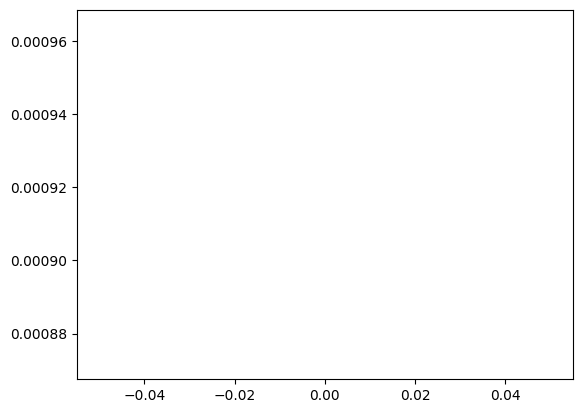

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from collections import Counter


class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        # self.dropout1 = nn.Dropout(p=dropout_rate) 
        self.fc2 = nn.Linear(4, 4)
        # self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(4, output_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return x

class QLearningAgent:
    def __init__(self, input_size, output_size, learning_rate, discount_factor, epsilon, batch_size=9000, replay_buffer_size=10000):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate) 
        self.loss_fn = nn.MSELoss()
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.learn_count = 0
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        
        # Action to index mapping
        self.action_to_index = {-1: 0, 0: 1, 1: 2}
        self.index_to_action = {0: -1, 1: 0, 2: 1}

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice([-1, 0, 1])  # Explore
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()  # Choose best action
            action = self.index_to_action[action_index]  # Map index to action
        return action

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        actions = torch.tensor([self.action_to_index[action] for action in actions], dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get max Q-value for the next states from target network
        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0].detach().view(-1, 1)
        target_q_values = rewards + self.discount_factor * next_q_values * (1 - dones).view(-1,1)

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        if self.learn_count%1000==0:
            for name, param in agent.q_network.named_parameters():
                if 'fc3' in name and param.requires_grad:
                    print(f"{name} grad: {param.grad}")
        self.optimizer.step()

        self.learn_count += 1
        # Update target network every few episodes
        if self.learn_count % 1 == 0:
            self.update_target_network()
        if self.learn_count % 100 == 0:
            self.epsilon = max(0.1, self.epsilon * 0.9885)
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

input_size = 6
output_size = 3 
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0

agent = QLearningAgent(input_size, output_size, learning_rate, discount_factor, epsilon)

## Training constants
total_episodes = 1
number_of_pairs = len(workingPairOutcome)
ls_total_reward = []

# Simulating agent learning (in practice, use a loop with environment interaction)
for episode in range(total_episodes):
    arr_pair_reward = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        pair_reward = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            if reward > 0:
                reward += 1
            elif reward<0:
                reward += -1

            agent.store_experience(state, action, reward, next_state, done)
            agent.learn()
            
            state = next_state

        arr_pair_reward[pair_idx] = pair_reward
    
    total_reward = arr_pair_reward.mean()
    print(f"Episode {episode+1}: Total Return: {total_reward:.3f}, Epsilon: {agent.epsilon:.2f}")
    # Capture total_reward for further analysis
    ls_total_reward.append(total_reward)

# evaluate random and final trained performance
plt.plot(ls_total_reward)

# After training, save the entire Q-network
torch.save(agent.q_network, 'q_network.pth')

### 11 Dec
- add back spread as one continuous variable for DQN
    - initial results is biased and resorts to shorting
- since its biased, try removing the dropout to get more fitting ==> still biased
- try reducing the epsilon to get more training
- Underfitting
  - remove dropout layers
  - increase learning rate
  - increase update to once every 2 learning
  - increase batch size to 8000
- reached 28 mins and ran out of memory
- run no. 2 gradient vanished. try again. == make sure to quit other apps ==
  - ***v20241211_1***
  - removed dropout layers
  - learning rate 0.9
  - update target every 2 learns
  - batch size 8000
  - 2 hidden layers 4x4 nn
  - changed relu to leaky relu ==> mean reverting!!!! but overfit.  (6mins~)
- try reducing neural net. v20241211_1 but changed learning rate to 0.1. less overfitting but negative performance


In [14]:
# loaded_q_network = torch.load('q_network_replay1batch_32x4.pth')

# loaded_q_network = QNetwork(6,3)  # Replace QNetwork with your model class
# loaded_q_network.eval()

In [15]:
def evaluate_agent(agent, env, number_of_pairs):
    """
    Evaluates the agent's performance over one episode without epsilon exploration.
    
    Parameters:
        agent (QLearningAgent): The trained agent.
        env: The environment with reset() and step() methods.
        number_of_pairs (int): Number of pairs to evaluate.

    Returns:
        float: The average total return across all pairs.
    """
    total_rewards = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        pair_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                # Select action based purely on Q-network (greedy action)
                q_values = agent.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()
                action = agent.index_to_action[action_index]
            
            # Take the selected action
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            state = next_state

        total_rewards[pair_idx] = pair_reward

    # Return the average reward across all pairs
    return total_rewards.mean()

agent.q_network.eval()
agent.target_network.eval()
# Example usage
average_return = evaluate_agent(agent, env, number_of_pairs)
print(f"Evaluation: Average Total Train Return: {average_return:.5f}")

Evaluation: Average Total Train Return: -0.11745


In [16]:
# Assuming states is a list of 6 states, each a list or NumPy array
states = [[0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]]

# Convert to PyTorch tensor (ensure float32 for compatibility)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Evaluate the Q-values for all states
agent.q_network.eval()  # Set the network to evaluation mode
with torch.no_grad():
    q_values = agent.q_network(states_tensor)  # Output will be a tensor of shape (6, output_size)

# Example: Get the greedy actions for each state
action_indices = torch.argmax(q_values, dim=1).tolist()
actions = [agent.index_to_action[index] for index in action_indices]

print("Q-values:", q_values)
print("Greedy actions:", actions)


Q-values: tensor([[13.2044, 13.2907, 13.2454],
        [12.6350, 12.5167, 12.4519],
        [ 9.9294,  9.7160,  9.7976],
        [13.3873, 13.7309, 13.6511],
        [12.7761, 12.6675, 12.5929],
        [11.5692, 11.4117, 11.4017]])
Greedy actions: [0, -1, -1, 0, -1, -1]


In [17]:
dict_policy_actions = dict(zip([tuple(state) for state in states], actions))
dict_policy_actions[(0, 0, 0, 0, 0, 0)] = 0
dict_policy_actions

{(0, 0, 0, 1, 0, 0): 0,
 (0, 0, 0, 1, 1, 0): -1,
 (0, 0, 0, 1, 1, 1): -1,
 (0, 0, 1, 0, 0, 0): 0,
 (0, 1, 1, 0, 0, 0): -1,
 (1, 1, 1, 0, 0, 0): -1,
 (0, 0, 0, 0, 0, 0): 0}

In [18]:
workingPairQresults = {}

for pair_idx in range(number_of_pairs):
    df = pd.DataFrame(workingPairOutcome[top_keys[pair_idx]], columns=dummy_df.columns)

    # Assign policy values using the dictionary
    df['position'] = df.apply(lambda row: dict_policy_actions.get(tuple(row), np.nan), axis=1)
    df[df.isna().any(axis=1)]
    pair = validPairsList[pair_idx]
    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values \
                    + df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values
    df['cumpnl'] = df['dailypnl'].cumsum()
    workingPairQresults[top_keys[pair_idx]] = df

In [19]:
total_q_return = 0
total_train_q_return = 0
total_test_q_return = 0

for pair in top_keys:
    total_q_return += workingPairQresults[pair]['cumpnl'].iloc[-2]
    total_train_q_return += workingPairQresults[pair]['cumpnl'].iloc[2868-2]


print(f"total return \t\t{total_q_return/len(top_keys):.5f}")
print(f"total train return \t{total_train_q_return/len(top_keys):.5f}")
print(f"total test return \t{(total_q_return - total_train_q_return)/len(top_keys):.5f}")

total return 		-0.03785
total train return 	-0.11745
total test return 	0.07960
